# Using JValue-ODS to Carry Out Multi-source Analysis of COVID Situation in Germany

Using open data for data science projects normally comes with many problems and hassles.

As the word _open_ indicates, it is open for consumption but also for publishing.

On the data publishers side, there is no consistent industry standard written on some _Rosetta Stone_.

It can even happen that data from the same publisher does not follow a consistent unified standard.

This results in a typical problem with _open data_: too much irregularity to detangle.

This makes it harder to keep your data pipelines sane and clean. Especially, when it comes to data science projects that use data from multiple different sources from multiple different publishers.

A research group at the _Professorship for Open Source Software_ at _FAU Erlangen-Nürnberg_ have built a solution that can compensate for the counter-productive effect of these irregularities.
The service is called __ODS__, short for __JValue Open Data Service__.

ODS provides a streamlining phase that can benefit both sides of the process.
It does so by providing the tooling needed to handle data collection, transformation, storage, etc. all through one service. In most cases, you set it up once -for a data source-, then you forget about it forever, knowing that __the data flow is on a roll__.


---

## Easier done than said

In this project, we will be using ODS to build, execute, and maintain data pipelines that fetch data from muliple datasources from different publishers.

>For this demo, we use the Python client library for ODS: PieODS.
If you don't have it installed, run this:
>>```
pip install PieODS
```

ODS has a microservices architecture, and is distributed in the form of docker images.
However, you only need to have docker up and running on your machine in order to use ODS.
If you use the Python client library PieODS, it can handle the underlying processes needed to ensure the latest versions of the images are loaded and running.

## Importing necessary modules and packages

Let's start with the necessary imports:
We will import the main module of the PieODS library. It contains the high-level wrapper around ODS services.
We will also need to import _Switch_ module, which handles the mechanics of ODS docker containers.

In [1]:
from PieODS import PieODS, Switch, helpers

## Starting an ODS instance

If you do not have a running ODS instance already, then you need to start one.
You can do so by executing "docker-compose up" command in the directory where the repository is cloned.

Alternatively, and more conveniently, PieODS provides 2 different methods to start an ODS instance:

1. Through the high-level wrapper module _Switch_.

2. Through terminal, directory-independent, by using PieODS CLI command "PieODS --service start".

For the moment, we are going to start an ODS instance for our project.

In [2]:
ods_client = Switch.ODSclient()
ods_client.start()

## Configuring daily COVID-19 statistics data source

As we have an ODS instance up and running, we can now proceed with data sources configurations.

For that we use the _DataSource_ class from the high-level wrapper module _PieODS_.

To create a _DataSource_ instance, you need to provide some input parameters.
Some are necessary, but most of them are not.

The available input parameters are listed below in the form of *name:type=default\_value*:

* protocol_type:str="HTTP" #can be HTTP or FTP
* location:str=None
* encoding:str="UTF-8" 
* default\_parameters:helpers.KVpairs=None #key:value pairs in the form of a _KVpairs_ object.
* format_type:Literal`["JSON","XML","CSV"]`="JSON" #If you work with CSV, you have to provide CSV parameters below.
* CSV_col_separtor: str=";"
* CSV_line_separator: str="\n"
* CSV_skip_first_data_row: bool=False
* CSV_first_row_as_header: bool=True
* first_execution:str="2018-10-07T01:32:00.123Z"
* interval:int = 60000 #in milliseconds
* periodic:bool  = False 
* author:str=None
* display_name: str =None #mostly for the UI -ODS web client-.
* license : str = None
* description:str = None 

In [3]:
daily_stats_data_source = PieODS.DataSource(location="https://api.corona-zahlen.org/states",
                                            periodic=True,
                                            interval = 3600000,
                                            author="RKI",
                                            display_name="COVID-19 Daily Stats by Province - Germany",
                                            description="Detailed breakdown of daily COVID-19 statistics by province in Germany."
                                            )
daily_stats_data_source.create() #this creates and configures the data source inside ODS. It now has an ID.

1

## Creating a pipeline

Let us now create a pipeline for that data source, in order to get the data fetched, transformed, and stored.

To create a pipeline, we need to provide a transformation mini-script, besides some meta data: author, display name, license, description, etc.

The transformation can be any valid _JavaScript_ code.
The barebones would be "return data;".

In [4]:
daily_stats_data_source.create_pipeline(transformation=("var final = {}; "
                                                        "for (var key in data.data) "
                                                        "{data.data[key]['date']=data.meta.lastUpdate; final[key]=data.data[key];}; " 
                                                        "return final;"),
                                        display_name="Daily COVID-19 Stats",
                                        description="Detailed daily COVID-19 statistics by province in Germany."
                                        )

92

## Configuring vaccination statistics data source

Vaccination statistics are available in their raw format as CSV files.
For that, we will need to provide CSV-specific parameters in order to configure the data source.
Then, we can create a pipeline.

In [5]:
vaccination_data_source = PieODS.DataSource(location="https://github.com/mathiasbynens/covid-19-vaccinations-germany/raw/main/data/data.csv",
                                            periodic=True,
                                            interval = 3600000,
                                            format_type="CSV",
                                            CSV_col_separtor=",",
                                            CSV_skip_first_data_row=True,
                                            author="RKI",
                                            display_name="COVID-19 Vaccination Data by Province - Germany",
                                            description="Detailed history of COVID-19 vaccine distribution in Germany."
                                            )
vaccination_data_source.create()
vaccination_data_source.create_pipeline(transformation=("var final = {}; var index=0; "
                                        "for (index = 0; index < data.length; ++index) "
                                        "{if (final.hasOwnProperty(data[index].date)) "
                                        "{final[data[index].date][data[index].state] = data[index].atLeastPartiallyVaccinatedPercent;} "
                                        "else {final[data[index].date] ={}; final[data[index].date][data[index].state] = data[index].atLeastPartiallyVaccinatedPercent;}}; "
                                        "return final;"),
                            display_name="Vaccinations Percentage",
                            description="Historical data of percentage of recipients of at least one vaccine shot per state"
                            )

93

## Configuring recovered COVID-19 patients statistics data source

Now, we can proceed with creating the next data source for our project.
It provides data on the number of recovered COVID-19 patients in Germany per province.
The data is provided in JSON format, so we will configure the data source accordingly, then we can create a pipeline.

In [6]:
recovery_data_source = PieODS.DataSource(location="https://api.corona-zahlen.org/states/history/recovered",
                                            periodic=True,
                                            interval = 3600000,
                                            author="RKI",
                                            display_name="Recovered COVID Patients",
                                            description="Detailed history of COVID-19 recovered patients data by Province in Germany."
                                            )
recovery_data_source.create()

recovery_data_source.create_pipeline(transformation=("var final = {}; "
                                    "for (var key in data.data) "
                                    "{var i=0; for (i= 0; i < data.data[key].history.length; ++i) "
                                    "{var d=data.data[key].history[i].date;"
                                    "if (final.hasOwnProperty(d)) "
                                    "{final[d][key]=data.data[key].history[i].recovered;}"
                                    "else{final[d]={};final[d][key]=data.data[key].history[i].recovered;}}} "
                                    "return final;"),
                                    display_name="Recovered COVID Patients",
                                    description="Detailed history of COVID-19 recovered patients data by Province in Germany."
                                    )

94

## Configuring COVID-19 deaths statistics data source

Now we configure a data source that provides statistics on COVID-19 deaths in Germany per province.
This can be done in the same way as recovered patients data source.
The below code will create the data source and build the pipeline.

In [7]:
deaths_data_source = PieODS.DataSource(location="https://api.corona-zahlen.org/states/history/deaths",
                                            periodic=True,
                                            interval = 3600000,
                                            author="RKI",
                                            display_name="COVID-related Deaths",
                                            description="Detailed history of COVID-19 deaths data by province in Germany."
                                            )
deaths_data_source.create()

deaths_data_source.create_pipeline(transformation=("var final = {}; "
                                "for (var key in data.data) "
                                "{var i=0; for (i= 0; i < data.data[key].history.length; ++i) "
                                "{var d=data.data[key].history[i].date;"
                                "if (final.hasOwnProperty(d)) "
                                "{final[d][key]=data.data[key].history[i].deaths;}"
                                "else{final[d]={};final[d][key]=data.data[key].history[i].deaths;}}} "
                                "return final;"),
                                display_name="COVID-related Deaths",
                                description="Detailed history of COVID-19 deaths data by province in Germany."
                                )

95

## Configuring COVID-19 cases history statistics data source

Now, we are done to our final data source for this project.
It provides a history of COVID-19 confirmed cases in Germany per province.

In [8]:
cases_data_source = PieODS.DataSource(location="https://api.corona-zahlen.org/states/history/cases",
                                            periodic=True,
                                            interval = 3600000,
                                            author="RKI",
                                            display_name="History of COVID Infections",
                                            description="Detailed history of COVID-19 infections data by province in Germany."
                                            )
cases_data_source.create()

cases_data_source.create_pipeline(transformation=("var final = {}; "
                                "for (var key in data.data) "
                                "{var i=0; for (i= 0; i < data.data[key].history.length; ++i) "
                                "{var d=data.data[key].history[i].date;if (final.hasOwnProperty(d)) "
                                "{final[d][key]=data.data[key].history[i].cases;}"
                                "else{final[d]={};final[d][key]=data.data[key].history[i].cases;}}} "
                                "return final;"),
                                display_name="COVID Cases History",
                                description="Detailed history of COVID-19 infections data by province in Germany."
                                )

96

## Setting up notifications for a pipeline

You might also want to get notified when data imports are triggered and a pipeline output is ready.
ODS offers three modes of notification:
* Slack
* Firebase
* Webhook

You guessed it right, we are interested in Slack notifications for the moment.

So, let's set up a Slack notification configuration for that pipeline.

I will only post the code as text, because you would need actual access information for a Slack notification to be set-up.

>```
from PieODS import Notification as nt
>
>nt_API = nt.NotificationAPI()
for d in [daily_stats_data_source,
          vaccination_data_source, 
          recovery_data_source, 
          deaths_data_source, 
          cases_data_source]:
    nt_API.create_notificationConfig(nt.NotificationWriteModel(d.pipeline_IDs[-1],
                                                              True,
                                                              "SLACK",
                                                              nt.SlackNotificationParameter(
                                                                                            "your_workspace_ID",
                                                                                            "your_channel_ID",
                                                                                            "your_secret"
                                                                                            )
                                                              )
                                    )
```



## Retreiving pipeline output

Now the time has come to actually use the data that is being collected and transformed.
For that, we need to query the pipelines for their data.
We do that using the convenience method *get\_latest\_single\_pipeline\_output* embedded in the _DataSource_ class from the high-level wrapper module _PieODS_.
It will always bring the freshest data in a neat form accoding to the predefined transformation.

In [9]:
latest_daily_data = daily_stats_data_source.get_latest_single_pipeline_output(daily_stats_data_source.pipeline_IDs[-1])
latest_vaccination_data = vaccination_data_source.get_latest_single_pipeline_output(vaccination_data_source.pipeline_IDs[-1])
latest_recovery_data = recovery_data_source.get_latest_single_pipeline_output(recovery_data_source.pipeline_IDs[-1])
latest_deaths_data = deaths_data_source.get_latest_single_pipeline_output(deaths_data_source.pipeline_IDs[-1])
latest_cases_data = cases_data_source.get_latest_single_pipeline_output(cases_data_source.pipeline_IDs[-1])

## Let the action begin!

Now we will play with the data to create a complete picture of the COVID-19 situation -against vaccination situation- in Germany per province.

First, let's pull provinces data from the daily statistics.

In [10]:
German_states = {}
for k in latest_daily_data:
    German_states[k]={"name":latest_daily_data[k]["name"], 
                    "population":latest_daily_data[k]["population"]}                    

Now, let's enlist time points for the year 2021 up till today.

In [17]:
#from datetime import date #in case you need to pass different dates. Ex: date(2021, 5, 1)
time_points = helpers.list_days_between()

We are now ready to gather the data from all data sources.

<IPython.core.display.Javascript object>


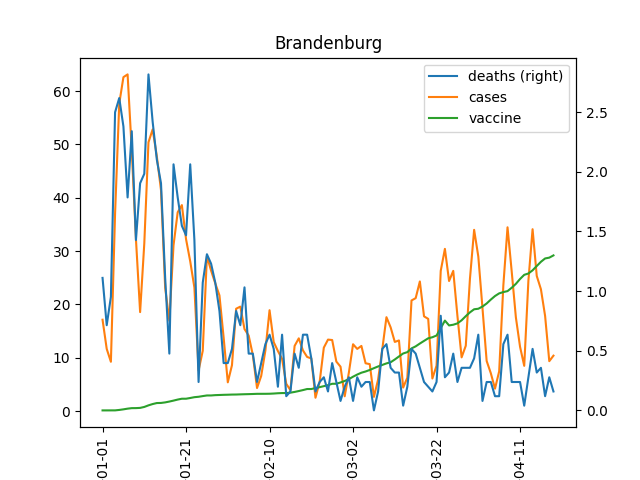

<IPython.core.display.Javascript object>


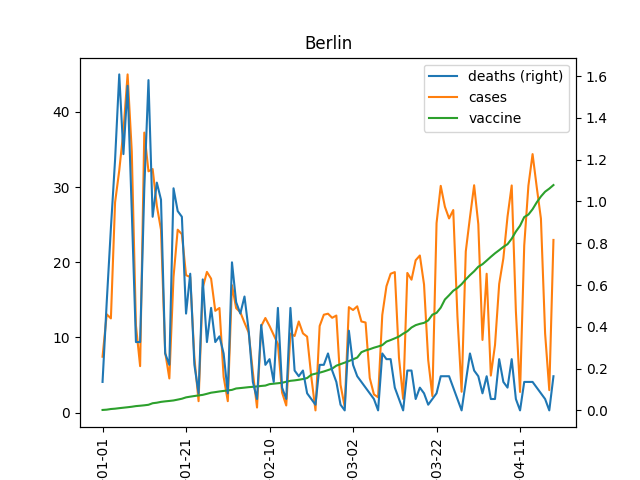

<IPython.core.display.Javascript object>


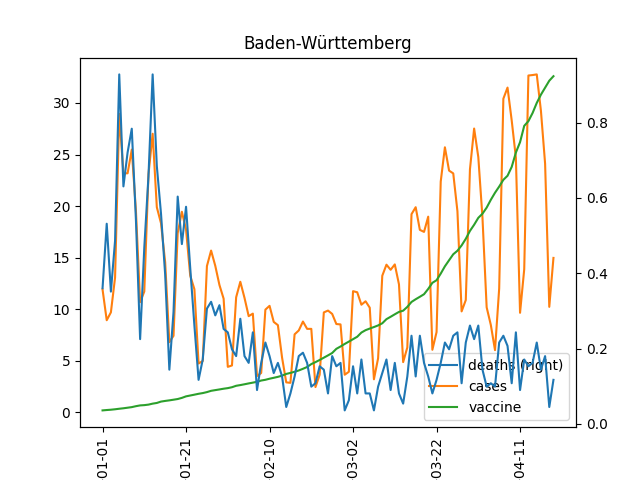

<IPython.core.display.Javascript object>


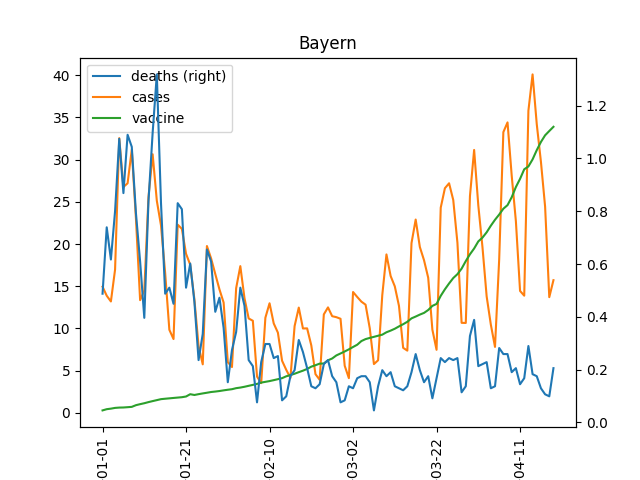

<IPython.core.display.Javascript object>


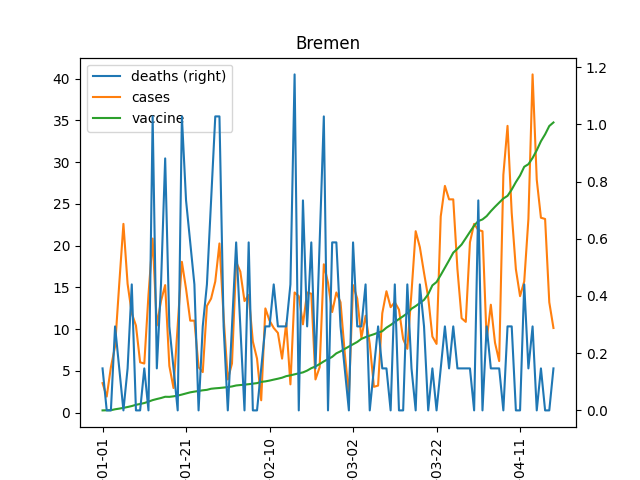

<IPython.core.display.Javascript object>


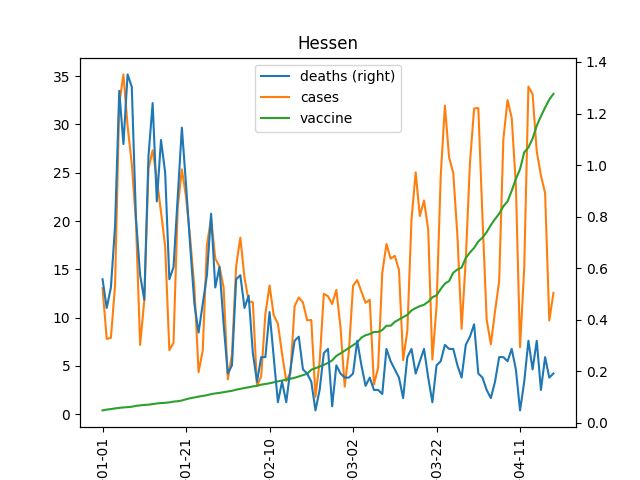

<IPython.core.display.Javascript object>


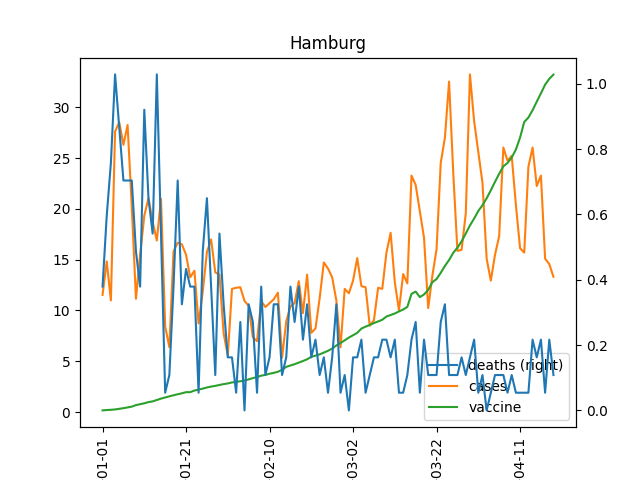

<IPython.core.display.Javascript object>


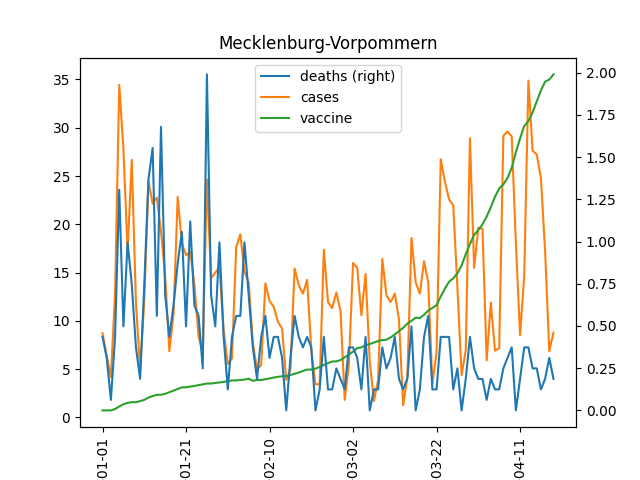

<IPython.core.display.Javascript object>


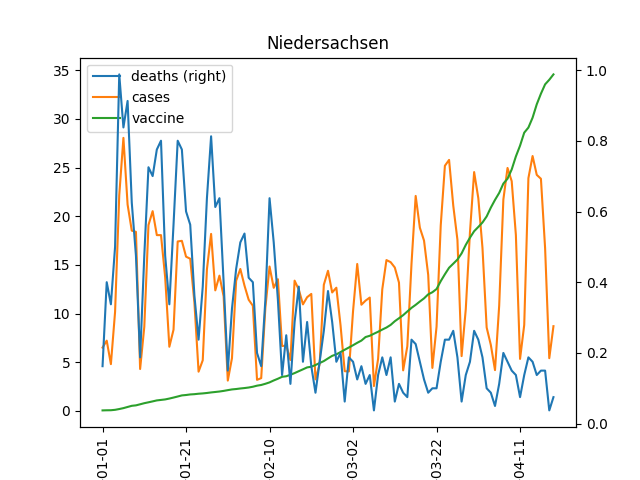

<IPython.core.display.Javascript object>


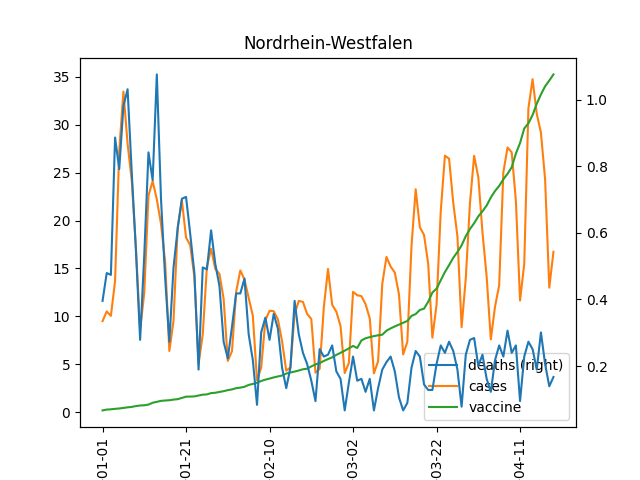

<IPython.core.display.Javascript object>


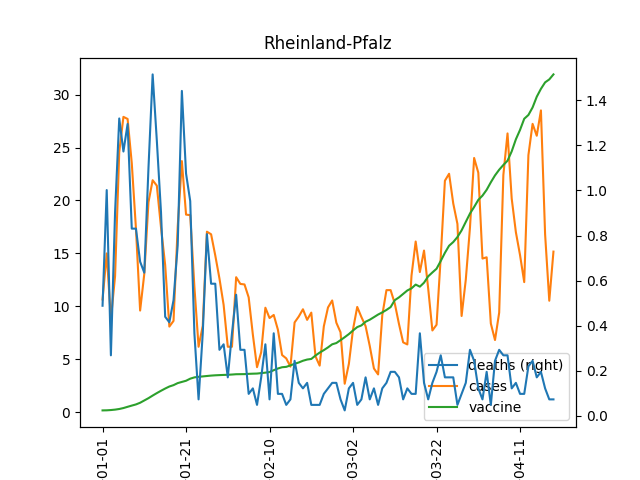

<IPython.core.display.Javascript object>


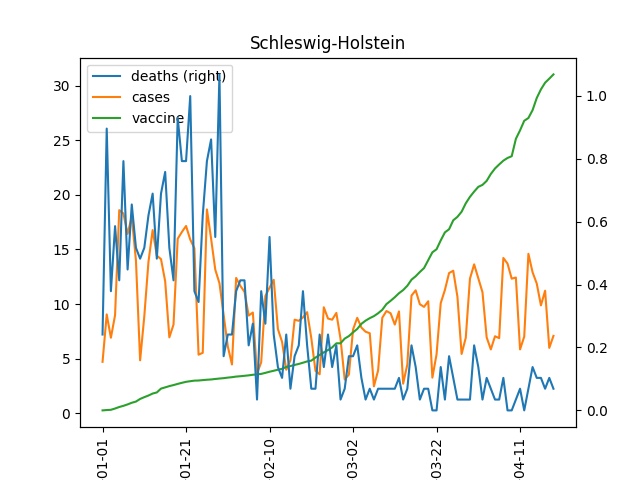

<IPython.core.display.Javascript object>


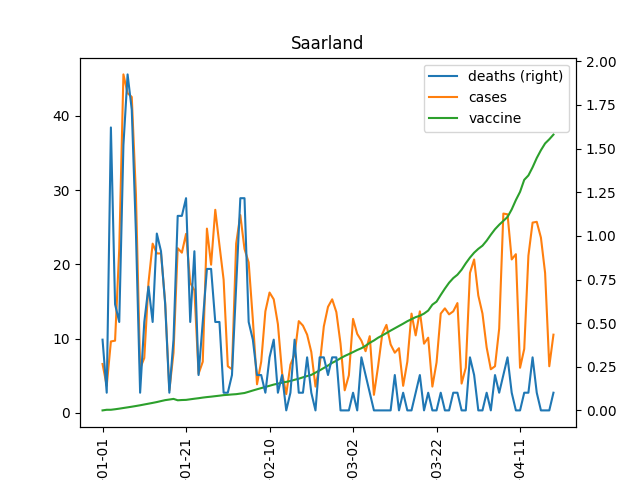

<IPython.core.display.Javascript object>


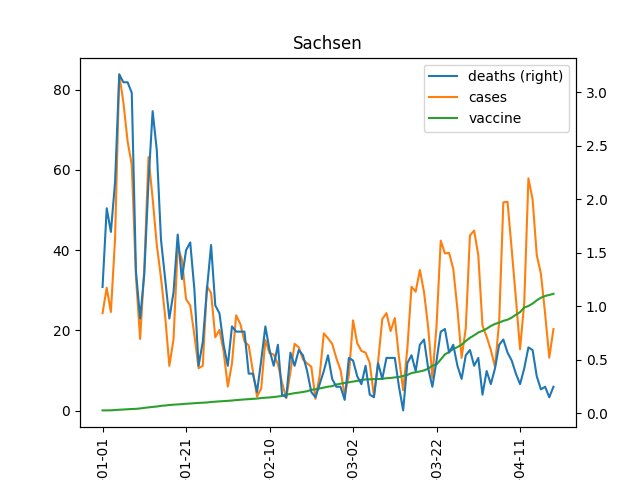

<IPython.core.display.Javascript object>


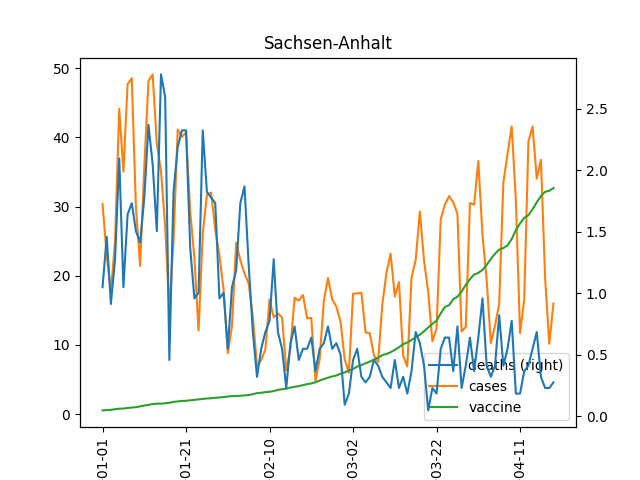

<IPython.core.display.Javascript object>


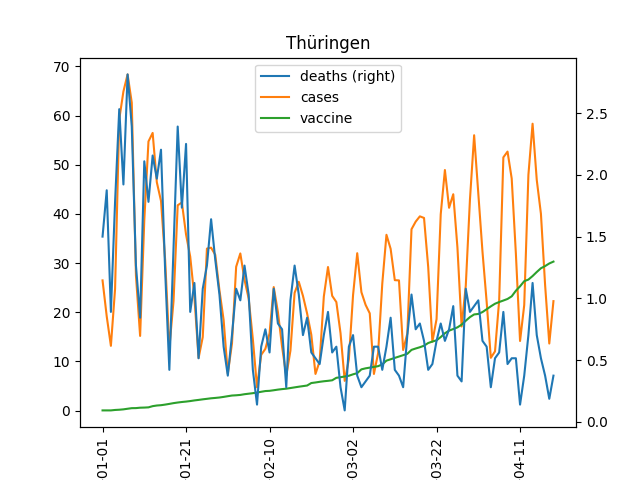

In [22]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt

keys = ["cases", "deaths", "recovered", "vaccine"]
covid_stats= {k:{"days":[], "cases":[], "deaths":[], "recovered":[], "vaccine":[]} for k in German_states}
for i, d in enumerate([latest_cases_data,
        latest_deaths_data,
        latest_recovery_data,
        latest_vaccination_data]):
    for c in d:
        if c[:10] in time_points:
            for s in d[c]:
                if len(s)<3:
                    if c[:10] not in covid_stats[s]["days"]:
                        covid_stats[s]["days"].append(c[:10])
                    per_100K = German_states[s]["population"]/100000 if i!=3 else 1
                    covid_stats[s][keys[i]].append(d[c][s]/per_100K)
                else:
                    matches = [k for k in German_states if German_states[k]["name"]==s]
                    if len(matches)!=0:
                        ab = matches[0]
                        if c[:10] not in covid_stats[ab]["days"]:
                            covid_stats[ab]["days"].append(c[:10])
                        covid_stats[ab][keys[i]].append(float(d[c][s]) if d[c][s]!="" else 0)

for k in covid_stats:
    for m in covid_stats[k]:
        covid_stats[k][m] = covid_stats[k][m][:len(covid_stats[k]["vaccine"])]

dfs = [(pd.DataFrame(covid_stats[st]), German_states[st]["name"]) for st in covid_stats]    

for d in dfs:
    d[0].plot(x=0, y=[ "deaths", "cases", "vaccine"],  sharex=True, rot=90, secondary_y=["deaths"], title=d[1])
plt.show(block=True)